In [1]:
import time
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd
from simple_pe.waveforms import parameter_bounds, check_physical
from simple_pe.param_est import find_metric_and_eigendirections

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [2]:
with open(os.path.join('data', '4d_samples_pe_result'), 'rb') as fp:
    pe_result = pickle.load(fp)
metric = pe_result.metric

In [60]:
def const_mm_point(metric, mm, target_par, base_vals, direction=1, del_dirs=[]):

    # Get metric
    keys = list(metric.dxs.keys())
    temp_metric = metric.metric.copy()
    for dd in del_dirs:
        ind = keys.index(dd)
        temp_metric = np.delete(temp_metric, (ind), axis=0)
        temp_metric = np.delete(temp_metric, (ind), axis=1)
        keys.remove(dd)

    # Find A
    target_ind = keys.index(target_par)
    A = temp_metric[target_ind][target_ind]

    # Find B
    param_keys = [key for key in keys if key != target_par]
    B = np.array([temp_metric[target_ind][k] for k in range(len(keys)) if k != target_ind])

    # Find inverse of C
    C = np.delete(temp_metric, (target_ind), axis=0)
    C = np.delete(C, (target_ind), axis=1)
    C_inv = np.linalg.inv(C)

    # Find change in target parameter to reach mismatch
    BC_term = -np.matmul(B, np.matmul(C_inv, B))
    d_target = direction*np.sqrt(mm/(A+BC_term))

    # Find extreme point at specified mismatch
    dxs = -1*np.matmul(C_inv, B) * d_target
    extreme_point = {target_par: base_vals[target_par]+d_target}
    for i, key in enumerate(param_keys):
        extreme_point[key] = dxs[i] + base_vals[key]

    return extreme_point

In [4]:
def degeneracy_line(metric, e10s, dirs=['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff'], mins=None, maxs=None):

    # Setup
    if mins is None:
        mins = parameter_bounds.param_mins
    if maxs is None:
        maxs = parameter_bounds.param_maxs
    base_vals = {direct: metric.x[direct][0] for direct in dirs}
    e10s = np.array([e10s]).flatten()
    rail_dirs = dirs.copy()
    rail_dirs.remove('ecc10sqrd')
    railing = []
    for i in range(len(e10s)):
        railing.append('0'*(len(dirs)-1))

    # Loop over iterations
    finished = np.zeros_like(e10s)
    degen_points = {}
    new_vals = [base_vals for i in range(len(e10s))]
    while np.sum(finished) < len(finished):

        # Calculate degenerate directions for all necessary projections
        for degen_key in set(railing):
            if degen_key not in degen_points.keys():
                del_dirs = [rail_dirs[i] for i in range(len(rail_dirs)) if int(degen_key[i])]
                degen_points[degen_key] = const_mm_point(metric, metric.mismatch, 'ecc10sqrd', base_vals, del_dirs=del_dirs)
                for direct in del_dirs:
                    degen_points[degen_key][direct] = base_vals[direct]

        # For each eccentricity value
        for i, e10 in enumerate(e10s):
            if finished[i]:
                continue

            # Calculate new value
            dist = (e10**2 - new_vals[i]['ecc10sqrd'])/(degen_points[railing[i]]['ecc10sqrd'] - base_vals['ecc10sqrd'])
            dx = {}
            for direct in dirs:
                dx[direct] = dist*(degen_points[railing[i]][direct] - base_vals[direct])
            new_vals_pos, dx_pos = new_vals[i].copy(), dx.copy()
            for key in list(dx_pos.keys()):
                if dx_pos[key] == 0:
                    new_vals_pos.pop(key)
                    dx_pos.pop(key)
            alpha = check_physical(new_vals_pos, dx_pos, 1, maxs=maxs, mins=mins)
            new_point = {}
            for direct in dirs:
                new_point[direct] = alpha*dist*(degen_points[railing[i]][direct] - base_vals[direct]) + new_vals[i][direct]
            new_vals[i] = new_point

            # Check if railing
            rail = ''
            if alpha < 1:
                for j, raildir in enumerate(rail_dirs):
                    if np.isclose(new_point[raildir], maxs[raildir], atol=1e-15) or np.isclose(new_point[raildir], mins[raildir], atol=1e-15):
                        rail += '1'
                    else:
                        rail += '0'
                if rail == railing[i]:
                    finished[i] = True
                else:
                    railing[i] = rail
            else:
                finished[i] = True

    # Return as array or single value
    new_vals = np.array(new_vals)
    if len(np.shape(new_vals.squeeze())) == 0:
        new_vals = new_vals[0]

    return new_vals

In [64]:
mins = parameter_bounds.param_mins.copy()
maxs = parameter_bounds.param_maxs.copy()
mins['symmetric_mass_ratio'] = 0.16
degeneracy_line(metric, np.linspace(0, 1, 6)**0.5, mins=mins, maxs=maxs)

array([{'ecc10sqrd': 0.0, 'chirp_mass': 24.70401677956892, 'symmetric_mass_ratio': 0.20611046902051516, 'chi_eff': 0.13994519741392042},
       {'ecc10sqrd': 0.19999999999999998, 'chirp_mass': 22.07337487757199, 'symmetric_mass_ratio': 0.18694140727618386, 'chi_eff': 0.011646628169455872},
       {'ecc10sqrd': 0.4, 'chirp_mass': 19.44273297557506, 'symmetric_mass_ratio': 0.1677723455318525, 'chi_eff': -0.11665194107500874},
       {'ecc10sqrd': 0.6000000000000001, 'chirp_mass': 16.87977247849784, 'symmetric_mass_ratio': 0.16, 'chi_eff': -0.2761073484624534},
       {'ecc10sqrd': 0.7999999999999999, 'chirp_mass': 14.362969423205586, 'symmetric_mass_ratio': 0.16, 'chi_eff': -0.45681113189194456},
       {'ecc10sqrd': 0.998001, 'chirp_mass': 11.871321814450976, 'symmetric_mass_ratio': 0.16, 'chi_eff': -0.6357087810060582}],
      dtype=object)

In [65]:
degeneracy_line(metric, np.linspace(0, 1, 6)**0.5)

array([{'ecc10sqrd': 0.0, 'chirp_mass': 24.70401677956892, 'symmetric_mass_ratio': 0.20611046902051516, 'chi_eff': 0.13994519741392042},
       {'ecc10sqrd': 0.19999999999999998, 'chirp_mass': 22.07337487757199, 'symmetric_mass_ratio': 0.18694140727618386, 'chi_eff': 0.011646628169455872},
       {'ecc10sqrd': 0.4, 'chirp_mass': 19.44273297557506, 'symmetric_mass_ratio': 0.1677723455318525, 'chi_eff': -0.11665194107500874},
       {'ecc10sqrd': 0.6000000000000001, 'chirp_mass': 16.812091073578127, 'symmetric_mass_ratio': 0.14860328378752116, 'chi_eff': -0.24495051031947335},
       {'ecc10sqrd': 0.7999999999999999, 'chirp_mass': 14.181449171581198, 'symmetric_mass_ratio': 0.12943422204318983, 'chi_eff': -0.3732490795639378},
       {'ecc10sqrd': 0.998001, 'chirp_mass': 11.577100535394726, 'symmetric_mass_ratio': 0.11045675507099308, 'chi_eff': -0.5002653046088039}],
      dtype=object)

# Test 3d metric

In [7]:
def generate_ellipsoid(metric, base_vals, npts=1000, scale=1):

    # Points on an n-dimensional sphere
    n = len(metric.evec)
    points = np.random.rand(n, npts)*2-1
    points /= np.linalg.norm(points, axis=0)

    # Transform to n-dimensional ellipsoid
    ellipse = np.matmul(metric.normalized_evecs().samples, scale*points)
    keys = list(metric.dxs.keys())

    # Recentre to base parameter values
    ellipse_dict = {}
    for i, key in enumerate(keys):
        ellipse_dict[key] = ellipse[i] + base_vals[key]

    return ellipse_dict

In [12]:
# Defines PSD settings
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': 20,
        'f_high': 8192,
        'length': 32
        }
snr = 18
psds['delta_f'] = 1. / psds['length']
approximant = 'TEOBResumS-Dali'

# Calculates PSD
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])
pycbc_psd['harm'] = 1. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

# Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
pars = {'chirp_mass':24, 'symmetric_mass_ratio':2/9, 'ecc10sqrd': 0, 'chi_eff': 0}
par_dirs = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio']

start = time.time()
metric_3d = find_metric_and_eigendirections(pars, par_dirs, snr=snr, approximant=approximant, f_low=psds['f_low'], psd=pycbc_psd['harm'])
end = time.time()
print(f'{end-start:.2f} seconds')

Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 


Calculating the metric | iteration 0 < 20| error 0.0095 > 0.00048

Initial frequency too high. Set f0 to 1.37e-02 


Calculating the metric | iteration 1 < 20| error 0.0018 > 0.00048: 

Initial frequency too high. Set f0 to 1.37e-02 


Calculating the metric | iteration 2 < 20| error 0.00046 > 0.00048: 

49.53 seconds


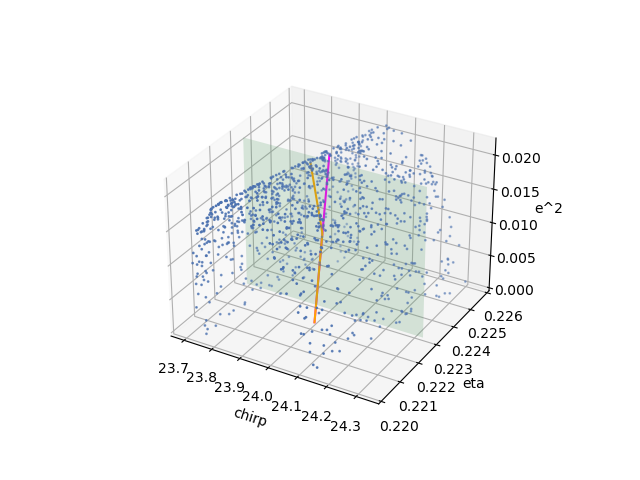

In [63]:
# Setup 3d plot
plt.close()
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
base_pars = {'ecc10sqrd': 0, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9}
ellipse_3d = generate_ellipsoid(metric_3d, base_pars, npts=25000, scale=1)
extreme_point = const_mm_point(metric_3d, metric_3d.mismatch, 'ecc10sqrd', base_pars)

# Cut unphysical parts of 3d ellipsoid or parts outside of plot
keep_inds = np.where(np.logical_and(np.logical_and(ellipse_3d['ecc10sqrd']>=0, ellipse_3d['symmetric_mass_ratio']<=0.226),
                                    ellipse_3d['symmetric_mass_ratio']>=0.22))[0]
for key in ellipse_3d.keys():
    ellipse_3d[key] = ellipse_3d[key][keep_inds]

# Plot 3d ellipsoid and degeneracy line
ax.scatter(ellipse_3d['chirp_mass'], ellipse_3d['symmetric_mass_ratio'], ellipse_3d['ecc10sqrd'], s=1, c='b')
chirp_line = np.linspace(base_pars['chirp_mass'], extreme_point['chirp_mass'], 101)
eta_line = np.linspace(base_pars['symmetric_mass_ratio'], extreme_point['symmetric_mass_ratio'], 101)
e2_line = np.linspace(base_pars['ecc10sqrd'], extreme_point['ecc10sqrd'], 101)
ax.plot(chirp_line, eta_line, e2_line, c='magenta')

# Plot plane and degeneracy line with plane as bound
xx, yy = np.meshgrid(ax.get_xlim(), [0.223, 0.223])
z = np.array([[0, 0], [0.022, 0.022]])
ax.plot_surface(xx, yy, z, color='g', alpha=0.2)
mins = parameter_bounds.param_mins.copy()
maxs = parameter_bounds.param_maxs.copy()
maxs['symmetric_mass_ratio'] = 0.223
degen_points = degeneracy_line(metric_3d, e2_line**0.5, dirs=['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio'], mins=mins, maxs=maxs)
chirp_line = [degen_points[i]['chirp_mass'] for i in range(len(degen_points))]
eta_line = [degen_points[i]['symmetric_mass_ratio'] for i in range(len(degen_points))]
ax.plot(chirp_line, eta_line, e2_line, c='orange')

# Plot formatting
ax.set_xlabel('chirp')
ax.set_ylabel('eta')
ax.set_zlabel('e^2')
ax.set_zlim(0,0.022)
ylim = ax.get_ylim()
ax.set_ylim(0.22, 0.226)
plt.show()

In [61]:
mins = parameter_bounds.param_mins.copy()
maxs = parameter_bounds.param_maxs.copy()
maxs['symmetric_mass_ratio'] = 2/9
degeneracy_line(metric_3d, np.linspace(0, 0.02, 6)**0.5, dirs=['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio'], mins=mins, maxs=maxs)

array([{'ecc10sqrd': 0.0, 'chirp_mass': 24.0, 'symmetric_mass_ratio': 0.2222222222222222},
       {'ecc10sqrd': 0.003999999999999999, 'chirp_mass': 23.983439373199886, 'symmetric_mass_ratio': 0.2222222222222222},
       {'ecc10sqrd': 0.008, 'chirp_mass': 23.96687874639977, 'symmetric_mass_ratio': 0.2222222222222222},
       {'ecc10sqrd': 0.012, 'chirp_mass': 23.950318119599658, 'symmetric_mass_ratio': 0.2222222222222222},
       {'ecc10sqrd': 0.015999999999999997, 'chirp_mass': 23.93375749279954, 'symmetric_mass_ratio': 0.2222222222222222},
       {'ecc10sqrd': 0.02, 'chirp_mass': 23.917196865999426, 'symmetric_mass_ratio': 0.2222222222222222}],
      dtype=object)

In [20]:
const_mm_point(metric_3d, metric_3d.mismatch*10, 'ecc10sqrd', base_pars)

{'ecc10sqrd': 0.06590477522021614,
 'chirp_mass': 23.8605385142266,
 'symmetric_mass_ratio': 0.2268248696266703}